# Loading and Cleaning Data

### Cleaning diabetic_data.csv

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set matplotlib visualisation style
plt.style.use('seaborn-v0_8-pastel')

In [4]:
# Load data from csv
diabetic_df = pd.read_csv('../data/diabetic_data.csv')

# Replacing missing values identified by '?' with nan
diabetic_df_clean = diabetic_df.replace('?', np.nan)

# Adding new column showing if patient was readmitted within 30 days (high-risk patients)
diabetic_df_clean['readmitted_binary'] = np.where(diabetic_df_clean['readmitted'] == '<30', 1, 0)

# Replacing `AfricanAmerican` with `African American` in race column
diabetic_df_clean['race'] = diabetic_df_clean['race'].replace('AfricanAmerican', 'African American')

# Creating csv of cleaned diabetic data
diabetic_df_clean.to_csv('../data/cleaned_diabetic_data.csv', index=False)

### Creating Separate csv Files from IDS_mapping.csv

In [5]:
# Processing `IDS_mapping.csv`
from io import StringIO

# Read file
with open('../data/IDS_mapping.csv', encoding='utf-8') as f:
    content = f.read()

# Split file into sections by blank lines
sections = [s.strip() for s in content.strip().split('\n,\n')]
sections

test_df = pd.read_csv(StringIO(sections[0]))

IDS_mapping_list = []
for section in sections:
    df = pd.read_csv(StringIO(section))
    IDS_mapping_list.append(df)

# Create names for each dataframe in list - these are the names to save csv files as
IDS_mapping_names = [
    'admission_type_id',
    'discharge_disposition_id',
    'admission_source_id'
]

# Looping through each dataframe and associated name and saving as separate csv files
for name, df in zip(IDS_mapping_names, IDS_mapping_list):
    df.to_csv(f'../data/{name}.csv', index=False)
    print(f'Saved: {name}.csv')

Saved: admission_type_id.csv
Saved: discharge_disposition_id.csv
Saved: admission_source_id.csv


# Readmission Overview

In [6]:
diabetic_df_clean

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,readmitted_binary
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,NO,0
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,Up,No,No,No,No,No,Ch,Yes,>30,0
2,64410,86047875,African American,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,Yes,NO,0
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,Up,No,No,No,No,No,Ch,Yes,NO,0
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,Steady,No,No,No,No,No,Ch,Yes,NO,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,African American,Male,[70-80),NaN,1,3,7,3,...,Down,No,No,No,No,No,Ch,Yes,>30,0
101762,443847782,74694222,African American,Female,[80-90),NaN,1,4,5,5,...,Steady,No,No,No,No,No,No,Yes,NO,0
101763,443854148,41088789,Caucasian,Male,[70-80),NaN,1,1,7,1,...,Down,No,No,No,No,No,Ch,Yes,NO,0
101764,443857166,31693671,Caucasian,Female,[80-90),NaN,2,3,7,10,...,Up,No,No,No,No,No,Ch,Yes,NO,0


readmitted_binary
0    90409
1    11357
Name: count, dtype: int64


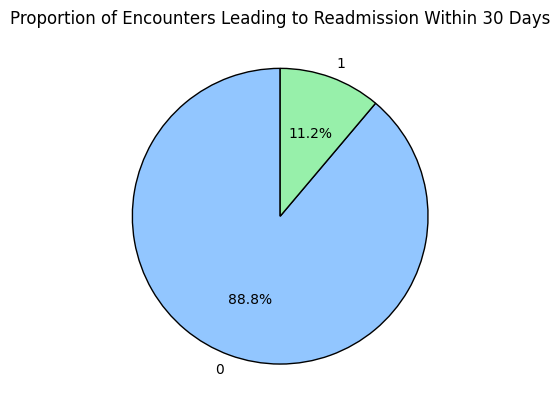

In [7]:
readmission_counts = diabetic_df_clean['readmitted_binary'].value_counts(dropna=False)
print(readmission_counts)

# Pie Chart
plt.pie(
    x=readmission_counts.values,
    labels=readmission_counts.index,
    startangle=90,
    autopct='%1.1f%%',
    wedgeprops={'edgecolor':'black'}
)
plt.title('Proportion of Encounters Leading to Readmission Within 30 Days')
plt.show()

Across all encounters, 11.2% (11,357 / 101,766) of these encounters were followed by a readmission of the patient within 30 days.

# Readmission by Patient Demographics

## Race

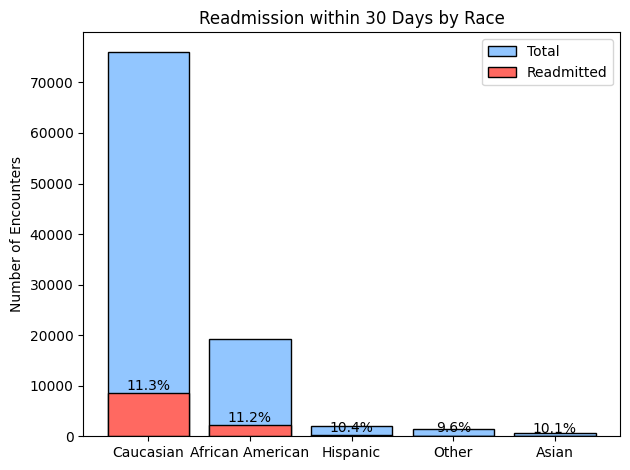

In [8]:
race_readmission = diabetic_df_clean[['race', 'readmitted_binary']]

# Total count of encounters and count of encounters with readmission within 30 days
total_by_race = race_readmission.groupby('race').size().rename('total')
race_readmission_count = race_readmission[race_readmission['readmitted_binary'] == 1].groupby('race').size().rename('readmitted')

# Summary dataframe
race_summary = pd.concat([race_readmission_count, total_by_race], axis=1).sort_values(by='total', ascending=False)
race_summary['percent_readmitted'] = 100 * race_summary['readmitted'] / race_summary['total']

# Plotting total bars
tot_bar = plt.bar(
    x=race_summary.index,
    height=race_summary['total'],
    label='Total',
    edgecolor='black'
)
# Plotting readmitted bars
read_bar = plt.bar(
    x=race_summary.index,
    height=race_summary['readmitted'],
    label='Readmitted',
    color='#FF6961',
    edgecolor='black'
)

# Add percent labels for each bar
for bar, pct in zip(read_bar, race_summary['percent_readmitted']):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 50,
        f'{pct:.1f}%',
        ha='center',
        va='bottom'
    )

# Adding graph elements
plt.title('Readmission within 30 Days by Race')
plt.ylabel('Number of Encounters')
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
# Provide information as table
race_summary.sort_values(by='percent_readmitted', ascending=False)

,readmitted,total,percent_readmitted
race,,,
Caucasian,8592,76099,11.290556
African American,2155,19210,11.218116
Hispanic,212,2037,10.407462
Asian,65,641,10.140406
Other,145,1506,9.628154


Readmission rates across the four different races and those classified as 'Other' show very little variation.

`Caucasian` patients had the highest readmission rate within 30 days of 11.3%.

The lowest readmission rate was 9.6% for patients classified as `Other`.

## Gender

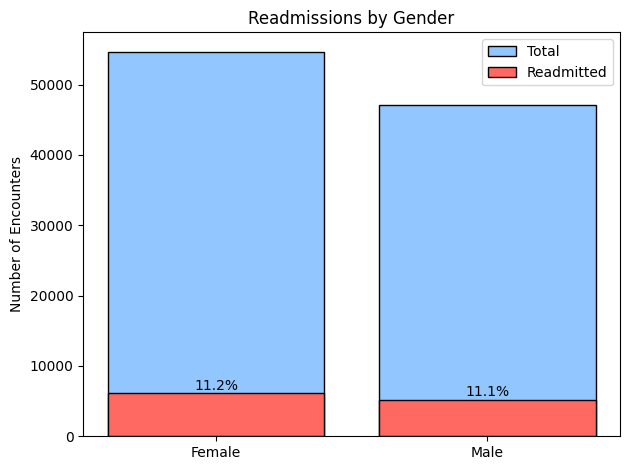

In [10]:
gender_readmission = diabetic_df_clean[['gender', 'readmitted_binary']]

# Drop rows where `gender` is 'Unknown/Invalid' as there are only 3 with this classification
gender_readmission = gender_readmission[gender_readmission['gender'] != 'Unknown/Invalid']

# Total and readmission within 30 days counts
readmission_by_gender = gender_readmission[gender_readmission['readmitted_binary'] == 1].groupby('gender').size().rename('readmitted')
total_by_gender = gender_readmission.groupby('gender').size().rename('total')

# Summary dataframe
gender_summary = pd.concat([readmission_by_gender, total_by_gender], axis=1)
gender_summary['percent_readmitted'] = 100 * gender_summary['readmitted'] / gender_summary['total']

# Plotting total bars
tot_bar = plt.bar(
    x=gender_summary.index,
    height=gender_summary['total'],
    label='Total',
    edgecolor='black'
)

# Plotting readmitted bars
read_bar = plt.bar(
    x=gender_summary.index,
    height=gender_summary['readmitted'],
    color='#FF6961',
    label='Readmitted',
    edgecolor='black'
)

# Adding percent readmitted labels
for bar, pct in zip(read_bar, gender_summary['percent_readmitted']):
    height=bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 50,
        f'{pct:.1f}%',
        ha='center',
        va='bottom'
    )

plt.title('Readmissions by Gender')
plt.ylabel('Number of Encounters')
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
# Provide information as table
gender_summary.sort_values(by='percent_readmitted', ascending=False)

,readmitted,total,percent_readmitted
gender,,,
Female,6152,54708,11.245156
Male,5205,47055,11.061524


Readmission rates are almost identical between female and male patients (11.2% and 11.1% respectively)

## Age

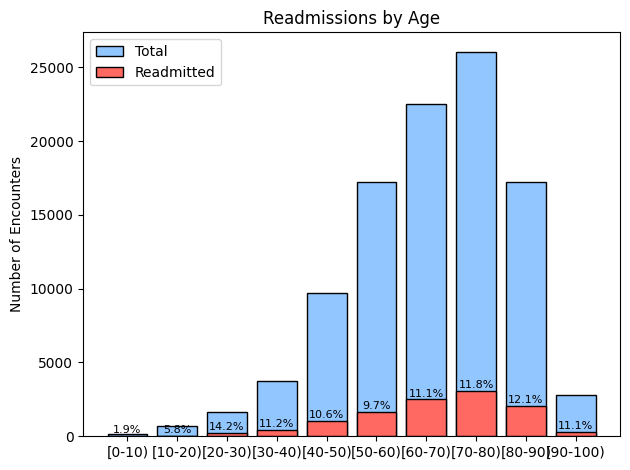

In [12]:
age_readmission = diabetic_df_clean[['age', 'readmitted_binary']]
age_readmission


# Total and readmission within 30 days counts
readmission_by_age = age_readmission[age_readmission['readmitted_binary'] == 1].groupby('age').size().rename('readmitted')
total_by_age = age_readmission.groupby('age').size().rename('total')

# Summary dataframe
age_summary = pd.concat([readmission_by_age, total_by_age], axis=1)
age_summary['percent_readmitted'] = 100 * age_summary['readmitted'] / age_summary['total']

# Plotting total bars
tot_bar = plt.bar(
    x=age_summary.index,
    height=age_summary['total'],
    label='Total',
    edgecolor='black'
)

# Plotting readmitted bars
read_bar = plt.bar(
    x=age_summary.index,
    height=age_summary['readmitted'],
    color='#FF6961',
    label='Readmitted',
    edgecolor='black'
)

# Adding percent readmitted labels
for bar, pct in zip(read_bar, age_summary['percent_readmitted']):
    height=bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 50,
        f'{pct:.1f}%',
        ha='center',
        va='bottom',
        fontsize=8
    )

plt.title('Readmissions by Age')
plt.ylabel('Number of Encounters')
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# Provide information as table
age_summary.sort_values(by='percent_readmitted', ascending=False)

,readmitted,total,percent_readmitted
age,,,
[20-30),236,1657,14.242607
[80-90),2078,17197,12.083503
[70-80),3069,26068,11.773055
[30-40),424,3775,11.231788
[60-70),2502,22483,11.128408
[90-100),310,2793,11.099177
[40-50),1027,9685,10.604027
[50-60),1668,17256,9.666203
[10-20),40,691,5.788712


Readmission rates differ significantly between different age brackets and show some interesting patterns.

Babies, children, and teenagers (age brackets `0-10` and `10-20`) show the lowest readmission rates (1.9% and 5.8% respectively). This could be due to diabetes encounters being less severe in these age groups, or patients in these age groups experiencing much better recoveries compared to older age groups.

Interestingly, young adults in the age bracket `20-30` have the highest readmission rate of 14.2%. This may be due to a diabetes diagnosis in young adults being associated with more severe illness, despite being much rarer than in older patients.

Alongside increasing number of encounters, there appears to be a decrease in readmission rates with increasing age between age brackets `20-30` through to `50-60`. Again, this suggests diabetes is more common with increasing age, but may be less severe and lower risk for older patients compared to younger patients up to a certain point.

Beyond the `50-60` age bracket, readmission rates increase with increasing age, up to 12.1% for patients aged `80-90`. This may be due to participants becoming more frail in their health beyond the age of 60.

The number of encounters where the patient was aged `80-90` and `90-100` show a decrease in frequency compared to the preceding age brackets. This might be due to higher mortality rates in these age groups, particularly for patients diagnosed with diabetes which is associated with lower life-expectancy.

There is a decrease in mortality rate for the oldest age bracket `90-100` (11.1%) compared to the second oldest age bracket `80-90` (12.1%). This could be due many different reasons. For example, patients in this age bracket may live in aged-care facilities where future issues are managed in-house rather than through readmission. Patients in this age bracket may also receive more conservative or community-based management of conditions compared to younger ages. Another potential explanation may be that this age group has a high mortality rate, which means mortality may occur before readmission can occur.

## Weight

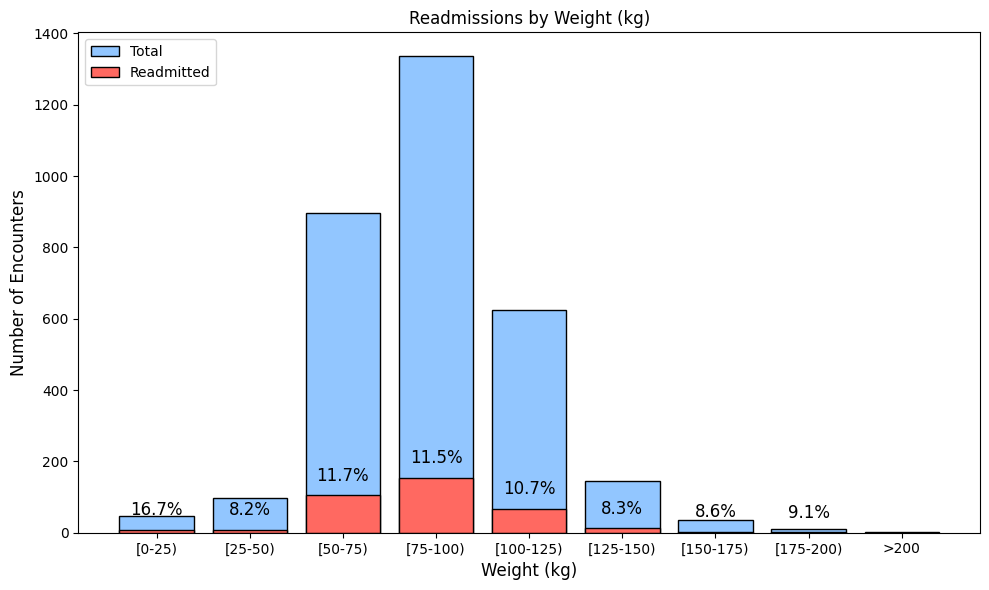

In [14]:
weight_readmission = diabetic_df_clean[['weight', 'readmitted_binary']]

# Total and readmission within 30 days counts
readmission_by_weight = weight_readmission[weight_readmission['readmitted_binary'] == 1].groupby('weight').size().rename('readmitted')
total_by_weight= weight_readmission.groupby('weight').size().rename('total')

# Summary dataframe
weight_summary = pd.concat([readmission_by_weight, total_by_weight], axis=1)
weight_summary['percent_readmitted'] = 100 * weight_summary['readmitted'] / weight_summary['total']

# Create function to extract lower bound of weight brackets for sorting these brackets
def extract_lower_bound(label):
    if label.startswith('['):
        return int(label[1:].split('-')[0])
    elif label.startswith('?'):
        return -1
    elif label.startswith('>'):
        return 9999
    else:
        return 0
    
# Sort age brackets in ascending order
sorted_index = sorted(weight_summary.index, key=extract_lower_bound)
weight_summary = weight_summary.reindex(index=sorted_index)

# Plotting total bars
plt.figure(figsize=(10,6))
tot_bar = plt.bar(
    x=weight_summary.index,
    height=weight_summary['total'],
    label='Total',
    edgecolor='black'
)

# Plotting readmitted bars
read_bar = plt.bar(
    x=weight_summary.index,
    height=weight_summary['readmitted'],
    color='#FF6961',
    label='Readmitted',
    edgecolor='black'
)

# Adding percent readmitted labels
for bar, pct in zip(read_bar, weight_summary['percent_readmitted']):
    height=bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 30,
        f'{pct:.1f}%',
        ha='center',
        va='bottom',
        fontsize=12
    )


plt.title('Readmissions by Weight (kg)')
plt.ylabel('Number of Encounters', fontsize=12)
plt.xlabel('Weight (kg)', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
# Provide information as table
weight_summary.sort_values(by='percent_readmitted', ascending=False)

,readmitted,total,percent_readmitted
weight,,,
[0-25),8.0,48,16.666667
[50-75),105.0,897,11.705686
[75-100),153.0,1336,11.452096
[100-125),67.0,625,10.720000
[175-200),1.0,11,9.090909
[150-175),3.0,35,8.571429
[125-150),12.0,145,8.275862
[25-50),8.0,97,8.247423
>200,NaN,3,NaN


Looking at the age brackets and their frequencies, it appears the data description which describes these weights as being in units of pounds (lbs) is likely incorrect. Most likely, these weights are in kilograms (kgs), as the frequencies align much better with typical body weight in kg. Therefore, the units will be assumed to be kg for this analysis.

Considering the lowest weight bracket `0-25`, it is possible that these contain many cases of inaccurate weight measurements, unless they are mostly made up of babies and young children.

Therefore, the ages of patients in this weight bracket is assessed below:

In [16]:
diabetic_df_clean[diabetic_df_clean['weight'] == '[0-25)']['age'].value_counts()

age
[70-80)    14
[60-70)    12
[40-50)     7
[80-90)     6
[50-60)     4
[0-10)      3
[30-40)     1
[20-30)     1
Name: count, dtype: int64

As shown, these patients within the `0-25` weight bracket are typically adults, with very few babies and young children. Therefore, patients in these categories are likely to have their weight recorded incorrectly.

It appears that patients of lower weight may have slightly higher readmission rates overall compared to patients of higher weight. This may be due to lower weight being associated with greater frailty and poorer health outcomes.

# Readmission by Hospital Features

## Admission Type

In [17]:
# Function to create dataframe by merging main dataframe with description dataframe using id column
def merge_description(col):

    # Loading csv
    csv = pd.read_csv(f'../data/{col}.csv')

    # Joining id with description from csv
    merged_df = pd.merge(diabetic_df_clean[[f'{col}', 'readmitted_binary']], csv, on=f'{col}')[[f'{col}', 'description', 'readmitted_binary']]
    return merged_df


In [18]:
# Function to take column name and create bar plot showing total encounters and readmitted encounters
def plot_col(col, vertical_barplot=True, xtick_rot=0, xtick_fontsize=10, ytickfontsize=10, figsize=(10,6), pct_fontsize=10, pct_rotation=0):
    # Columns that need to be joined with description from csv files
    if col in ['admission_source_id', 'admission_type_id', 'discharge_disposition_id'] :
        filtered_df = merge_description(col)

        # Total and readmission within 30 days counts
        readmission_by_col = filtered_df[filtered_df['readmitted_binary'] == 1].groupby('description').size().rename('readmitted')
        total_by_col= filtered_df.groupby('description').size().rename('total')

    # Columns that don't need merging with description
    else:
        filtered_df = diabetic_df_clean[[f'{col}', 'readmitted_binary']]

        # Total and readmission within 30 days counts
        readmission_by_col = filtered_df[filtered_df['readmitted_binary'] == 1].groupby(f'{col}').size().rename('readmitted')
        total_by_col= filtered_df.groupby(f'{col}').size().rename('total')

    # Summary dataframe
    col_summary = pd.concat([readmission_by_col, total_by_col], axis=1)
    col_summary['percent_readmitted'] = 100 * col_summary['readmitted'] / col_summary['total']

    if vertical_barplot == True:

        # Sort summary dataframe by count of categorical variables. If the column is an integer, it will be sorted in ascending order of integers
        if col_summary.index.dtype != 'int64':
            col_summary = col_summary.sort_values(by='total', ascending=False)

        # Plotting total bars
        plt.figure(figsize=figsize)
        tot_bar = plt.bar(
            x=col_summary.index.astype(str),
            height=col_summary['total'],
            label='Total',
            edgecolor='black'
        )

        # Plotting readmitted bars
        read_bar = plt.bar(
            x=col_summary.index,
            height=col_summary['readmitted'],
            color='#FF6961',
            label='Readmitted',
            edgecolor='black'
        )

        # Adding percent readmitted labels
        for bar, pct in zip(read_bar, col_summary['percent_readmitted']):
            height=bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                height + 30,
                f'{pct:.1f}%',
                ha='center',
                va='bottom',
                fontsize=pct_fontsize,
                rotation=pct_rotation
            )

        # # If the x axis value ticks are integer type, ensure each number appears on the plot (avoid skipping numbers)
        # if diabetic_df_clean[f'{col}'].dtype == 'int64':
        #     plt.xticks(range(diabetic_df_clean[f'{col}'].min(), diabetic_df_clean[f'{col}'].max() + 1), rotation=xtick_rot, fontsize=xtick_fontsize)
        # else:
        #     plt.xticks(rotation=xtick_rot, fontsize=xtick_fontsize)

        plt.title(f'Readmissions by {col}', fontsize=14)
        plt.xlabel('', fontsize=12)
        plt.ylabel('Number of Encounters', fontsize=12)
        plt.xticks(rotation=xtick_rot, fontsize=xtick_fontsize)
        plt.yticks(fontsize=ytickfontsize)
        plt.legend(fontsize=12, loc='upper right')
        plt.tight_layout()
        plt.show()

    else:
        col_summary = col_summary.sort_values(by='total', ascending=True)

        # Plotting total bars
        plt.figure(figsize=figsize)
        tot_bar = plt.barh(
            y=col_summary.index.astype(str),
            width=col_summary['total'],
            label='Total',
            edgecolor='black'
        )

        # Plotting readmitted bars
        read_bar = plt.barh(
            y=col_summary.index,
            width=col_summary['readmitted'],
            color='#FF6961',
            label='Readmitted',
            edgecolor='black'
        )

        # Adding percent readmitted labels
        for bar, pct in zip(read_bar, col_summary['percent_readmitted']):
            width=bar.get_width()
            plt.text(
                width + 1,
                bar.get_y() + bar.get_height() / 2,
                f'{pct:.1f}%',
                ha='left',
                va='center',
                fontsize=pct_fontsize,
                rotation=pct_rotation
            )

        plt.title(f'Readmissions by {col}', fontsize=14)
        plt.xlabel('Number of Encounters', fontsize=12)
        plt.xticks(rotation=xtick_rot, fontsize=xtick_fontsize)
        plt.yticks(fontsize=ytickfontsize)
        plt.legend(fontsize=12, loc='lower right')
        plt.tight_layout()
        plt.show()

    # Printing summary dataframe ordered by readmission rate
    print(col_summary.sort_values(by='percent_readmitted', ascending=False))

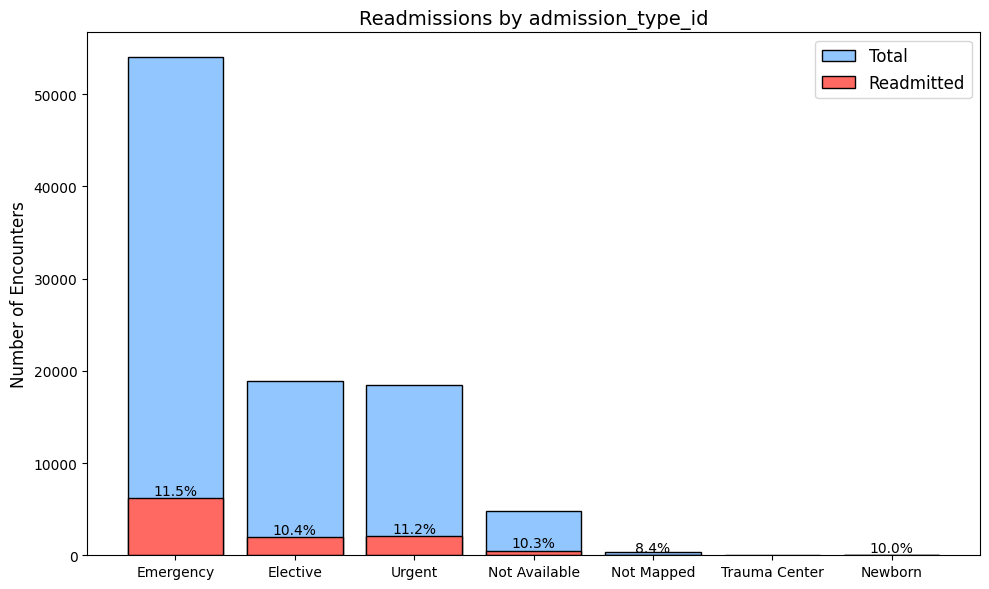

               readmitted  total  percent_readmitted
description                                         
Emergency          6221.0  53990           11.522504
Urgent             2066.0  18480           11.179654
Elective           1961.0  18869           10.392708
Not Available       495.0   4785           10.344828
Newborn               1.0     10           10.000000
Not Mapped           27.0    320            8.437500
Trauma Center         NaN     21                 NaN


In [19]:
# Using custom plotting function to create `Admission Type` readmitted vs total bar plot and table
plot_col('admission_type_id')

Emergency admissions form a significant majority of encounters. Elective and Urgent admissions are the next most common admission types, with similar frequencies to each other. Other Admission types are much less frequent.

Readmission rates do not appear to differ significantly between admission types.

## Admission Source

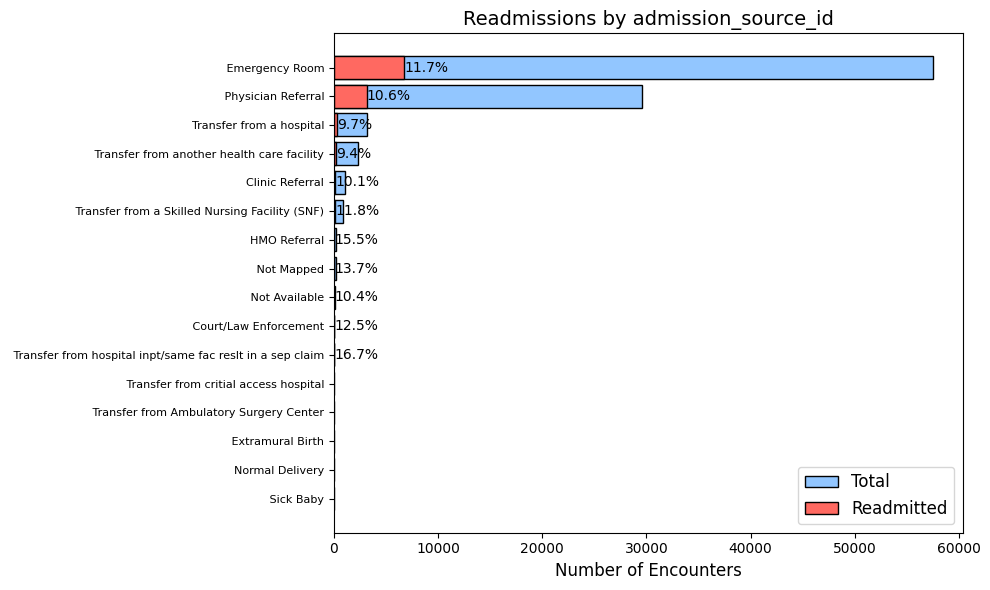

                                                    readmitted  total  \
description                                                             
 Transfer from hospital inpt/same fac reslt in ...         2.0     12   
HMO Referral                                              29.0    187   
 Not Mapped                                               22.0    161   
 Court/Law Enforcement                                     2.0     16   
 Transfer from a Skilled Nursing Facility (SNF)          101.0    855   
 Emergency Room                                         6720.0  57494   
 Physician Referral                                     3130.0  29565   
 Not Available                                            13.0    125   
Clinic Referral                                          111.0   1104   
Transfer from a hospital                                 309.0   3187   
 Transfer from another health care facility              212.0   2264   
 Sick Baby                                         

In [20]:
# Using custom plotting function to create `Admission Source` readmitted vs total bar plot and table
plot_col('admission_source_id', vertical_barplot=False, ytickfontsize=8)

`Emergency Room` serves as the most common source of encounters by a significant margin, followed by `Physician Referral`.

Other sources of encounters are much less common, with some sources having no associated encounters.

Most sources appear to have similar readmission rates, with `Transfer from hospital inpt/same fac reslt in a sep claim` and `HMO Referral` possibly being associated with a marginally higher readmission rate.

## Discharge Disposition

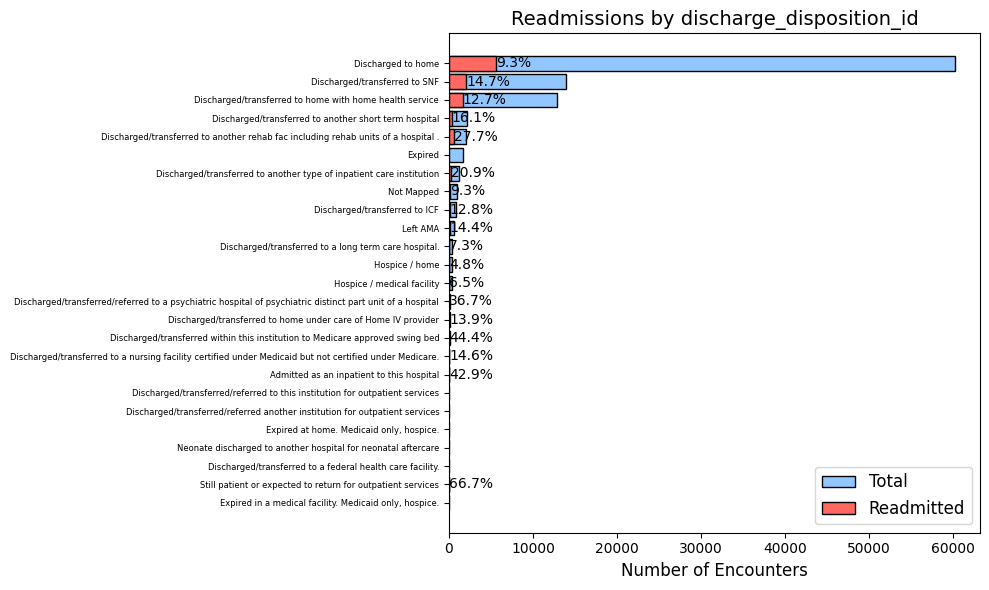

                                                    readmitted  total  \
description                                                             
Still patient or expected to return for outpati...         2.0      3   
Discharged/transferred within this institution ...        28.0     63   
Admitted as an inpatient to this hospital                  9.0     21   
Discharged/transferred/referred to a psychiatri...        51.0    139   
Discharged/transferred to another rehab fac inc...       552.0   1993   
Discharged/transferred to another type of inpat...       247.0   1184   
Discharged/transferred to another short term ho...       342.0   2128   
Discharged/transferred to SNF                           2046.0  13954   
Discharged/transferred to a nursing facility ce...         7.0     48   
Left AMA                                                  90.0    623   
Discharged/transferred to home under care of Ho...        15.0    108   
Discharged/transferred to ICF                      

In [21]:
# Using custom plotting function to create `Admission Source` readmitted vs total bar plot and table
plot_col('discharge_disposition_id', vertical_barplot=False, ytickfontsize=6)

The most common discharge disposition is `Discharged to home` by a large margin. `Discharged/transferred to SNF` and `Discharged/transferred to home with home health service` follow as the second and third most frequent discharge dispositions. Other discharge dispositions are much less frequent.

The highest readmission rate is 66.7% for `Still patient or expected to return for outpatient services`. The very high readmission rate is explained by the fact that some of the patients are already expected to return on discharge.

The second highest readmission rate is 44.4% for `Discharged/transferred within this institution to Medicare approved swing bed`, followed closely by `Admitted as an inpatient to this hospital` with a readmission rate of 42.9%. This indicates encounters where the patient remained within the same institution on discharge experience very high readmission rates. This is likely due to encounters not being fully resolved on discharge due to being more severe cases with worse recovery outcomes.

Patients discharged/transferred/referred to psychiatric hospital follow with a high readmission rate of 36.7%. Patients with psychiatric illnesses often experience poorer health outcomes, so those with comorbid diabetes and psychiatric illness may be at particularly elevated risk of more severe illness requiring hospital readmission.

Patients discharged to facilities which provide greater levels of long-term support experience lower readmission rates. This could be due to patients having low severity illness on discharge, and the fact that their conditions can be managed adequately within these facilities.

Patients who were `Discharged to home` experienced a relatively low readmission rate of 9.3%, likely due to their conditions being well-managed at the time they were discharged.

Patients discharged to Hospice facilities had the lowest rates of readmission. This may due to Hospice facilities taking over patient care and performing end-of-life care rather than readmitting a patient.

## Time in Hospital

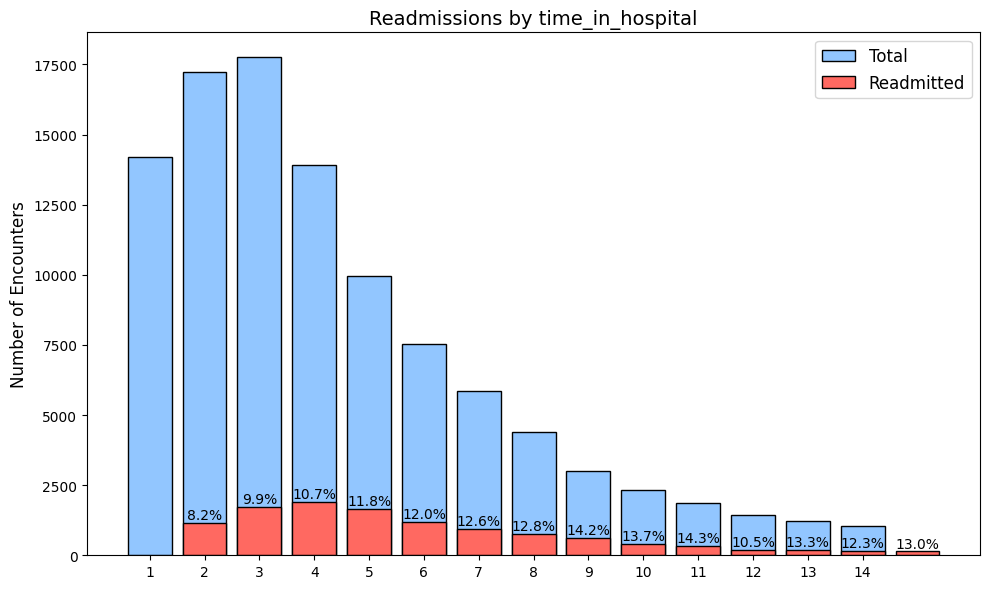

                  readmitted  total  percent_readmitted
time_in_hospital                                       
10                       336   2342           14.346712
8                        625   4391           14.233660
9                        412   3002           13.724184
12                       193   1448           13.328729
14                       135   1042           12.955854
7                        752   5859           12.834955
6                        949   7539           12.587876
13                       149   1210           12.314050
5                       1199   9966           12.030905
4                       1644  13924           11.806952
3                       1894  17756           10.666817
11                       195   1855           10.512129
2                       1712  17224            9.939619
1                       1162  14208            8.178491


In [22]:
# Using custom plotting function to create `Time in Hospital` readmitted vs total bar plot and table
plot_col('time_in_hospital')

Time in hospital has a right skew, with many encounters being shorter, lasting between 1 to 4 hours. An encounter duration of 3 hours is most frequent, with longer durations becoming increasingly less common.

Encounters with longer durations appear to typically have higher rates of readmission, which makes intuitive sense, as longer encounter times are likely associated with more serious illness, which in turn is associated with higher risk of readmission.

## Payer Code

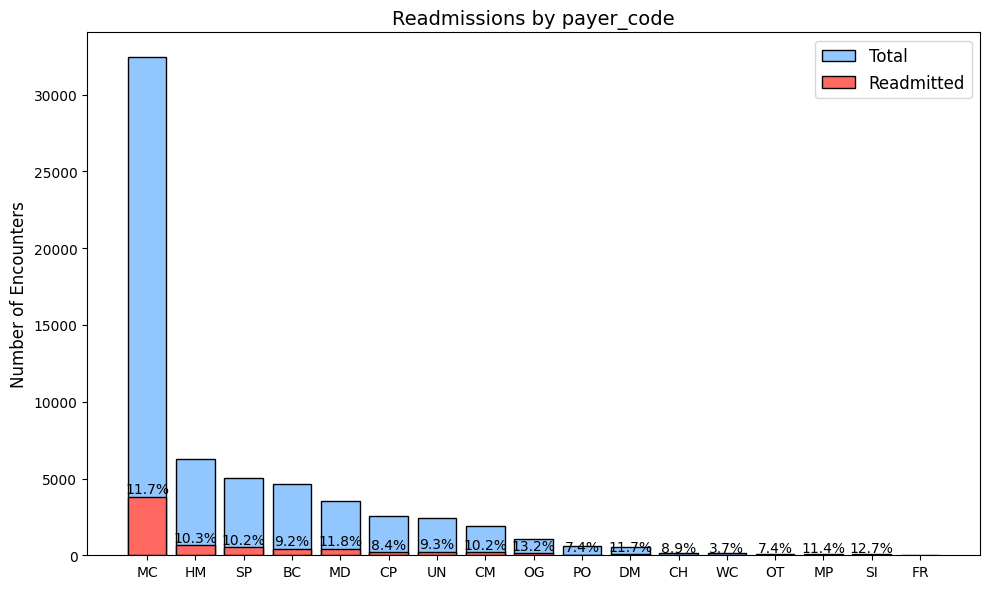

            readmitted  total  percent_readmitted
payer_code                                       
OG               136.0   1033           13.165537
SI                 7.0     55           12.727273
MD               416.0   3532           11.778029
MC              3810.0  32439           11.745122
DM                64.0    549           11.657559
MP                 9.0     79           11.392405
HM               644.0   6274           10.264584
CM               198.0   1937           10.221993
SP               510.0   5007           10.185740
UN               227.0   2448            9.272876
BC               426.0   4655            9.151450
CH                13.0    146            8.904110
CP               214.0   2533            8.448480
PO                44.0    592            7.432432
OT                 7.0     95            7.368421
WC                 5.0    135            3.703704
FR                 NaN      1                 NaN


In [23]:
# Using custom plotting function to create `Payer Code` readmitted vs total bar plot and table
plot_col('payer_code')

Payer code `MC` is the most frequent by a very large margin with 32,439 encounters, compared to the second most common code `HM` with 6,274 encounters.

There appears to be a large difference in readmission rates between different payer codes, with payer code `OG` having the highest readmission rate of 13.2% and payer code `WC` having the lowest readmission rate of 3.7%. These two payer codes stand out from the other payer codes, differing by a relatively large margin compared to the other readmission rates.

## Medical Speciality

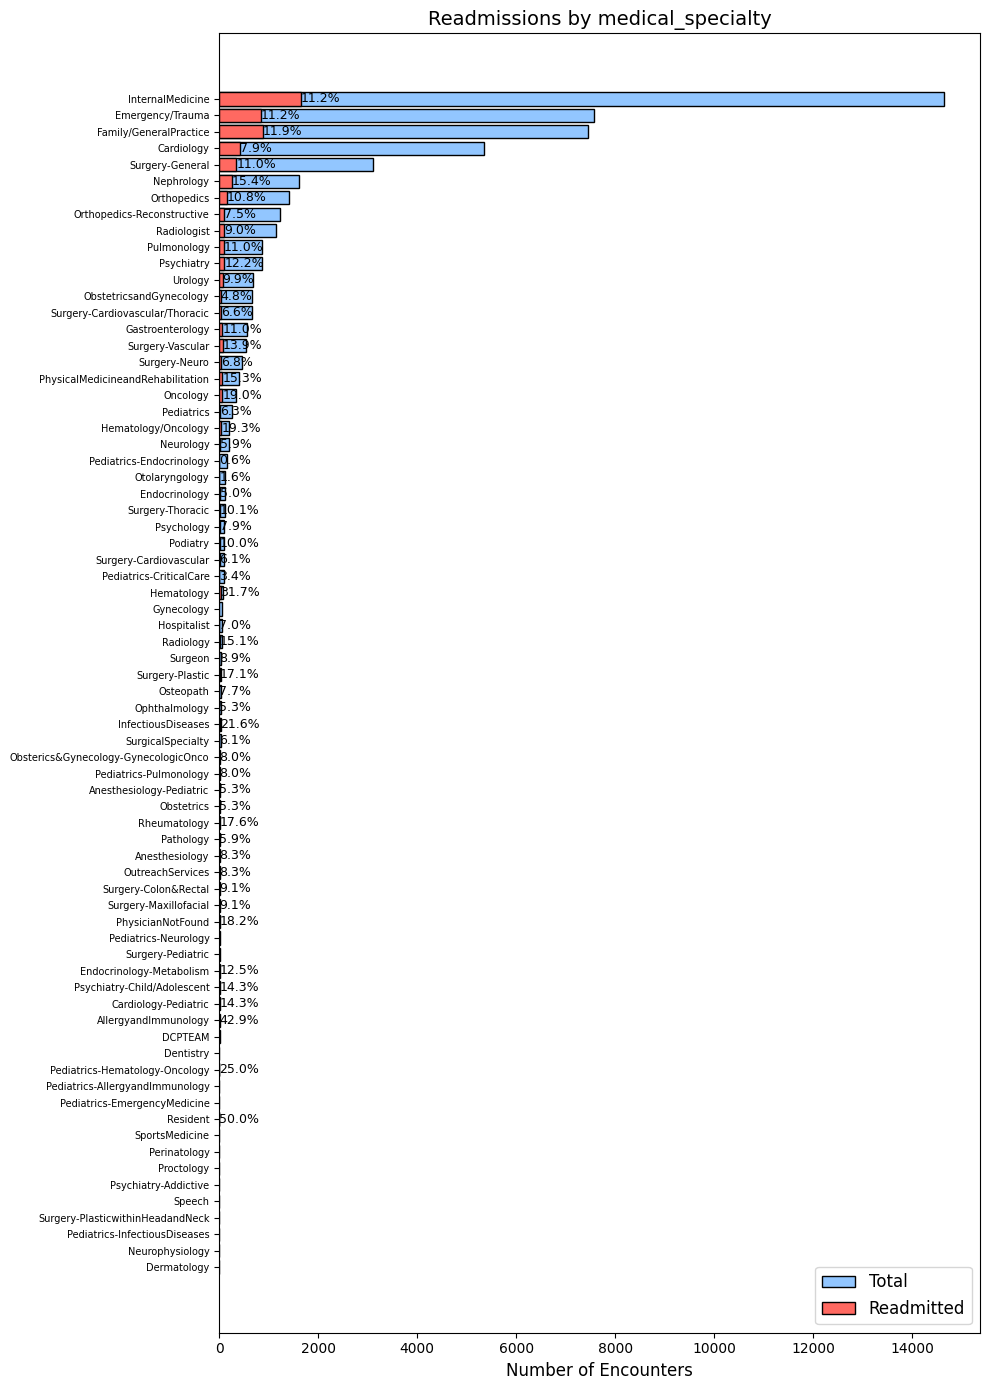

                                readmitted  total  percent_readmitted
medical_specialty                                                    
Resident                               1.0      2           50.000000
AllergyandImmunology                   3.0      7           42.857143
Hematology                            26.0     82           31.707317
Pediatrics-Hematology-Oncology         1.0      4           25.000000
InfectiousDiseases                     8.0     37           21.621622
...                                    ...    ...                 ...
Dentistry                              NaN      4                 NaN
DCPTEAM                                NaN      6                 NaN
Surgery-Pediatric                      NaN      8                 NaN
Pediatrics-Neurology                   NaN     10                 NaN
Gynecology                             NaN     58                 NaN

[72 rows x 3 columns]


In [24]:
# Using custom plotting function to create `Payer Code` readmitted vs total bar plot and table
plot_col('medical_specialty', vertical_barplot=False, ytickfontsize=7, figsize=(10,14), pct_fontsize=9)

`InternalMedicine` is the specialty with the highest number of encounters (14,635) by a large margin, followed by `Emergency/Trauma` (7,565) and `Family/GeneralPractice` (7,440).

Readmission rates vary widely between different specialties. The `Resident` specialty has a readmission rate of 50%, however, there were only two encounters with this specialty. Similarly, other specialties with very high readmission rates typically have very low numbers of encounters, so these observations are likely due to chance rather than due to differences between specialties.

Of the more common medical specialties, `Cardiology` stands out with a low readmission rate of 7.9%, which interestingly is higher than the readmission rate of 11.9% for `Family/GeneralPractice`.

## Number of Lab Procedures

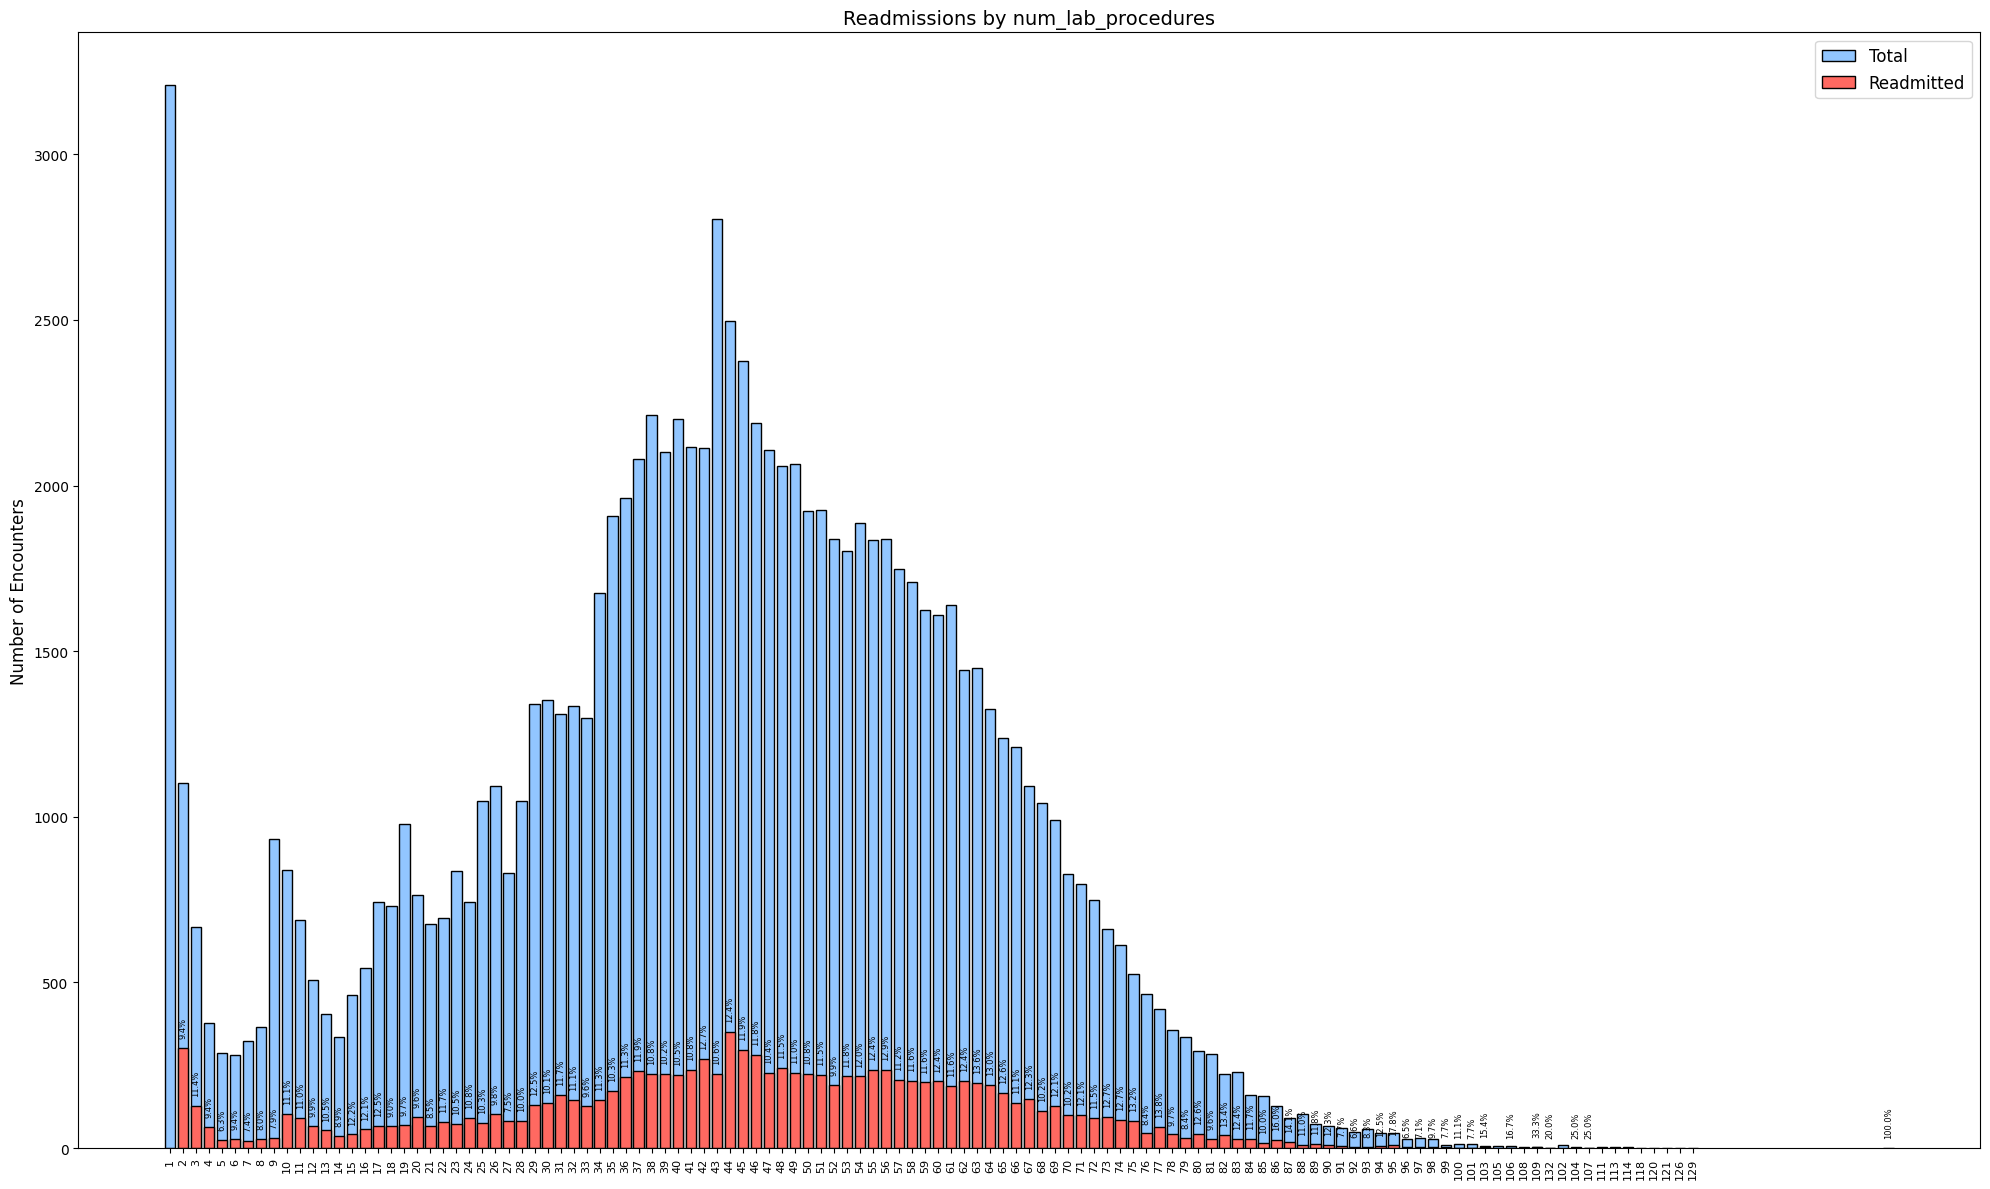

                    readmitted  total  percent_readmitted
num_lab_procedures                                       
132                        1.0      1          100.000000
105                        2.0      6           33.333333
109                        1.0      4           25.000000
108                        1.0      4           25.000000
106                        1.0      5           20.000000
...                        ...    ...                 ...
118                        NaN      1                 NaN
120                        NaN      1                 NaN
121                        NaN      1                 NaN
126                        NaN      1                 NaN
129                        NaN      1                 NaN

[118 rows x 3 columns]


In [25]:
plot_col('num_lab_procedures', figsize=(20,12), xtick_fontsize=8, pct_fontsize=6, xtick_rot=90, pct_rotation=90)